In [1]:
import sys
!{sys.executable} -m pip install opencv-python
!{sys.executable} -m pip install networkx
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib


In [2]:
import cv2
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt


In [3]:
def find_paths(graph):
    components = nx.connected_components(graph)
    paths = {}
    for c in components:
        component = graph.subgraph(c)
        start = next(filter(lambda node: component.degree(node) != 2, component.nodes), None)
        if start is None:
            start = next(iter(component.nodes))
        stack: list[any, tuple[any, any]] = []
        visited = set()
        for start_neighbor in component.neighbors(start):
            stack.append((start_neighbor, (start, start_neighbor)))
            paths[(start, start_neighbor)] = []
        visited.add(start)

        while stack:
            node, path_name = stack.pop()
            branch_parent = path_name[0]

            if node not in visited:
                if not paths.get(path_name, None):
                    paths[path_name] = [branch_parent]

                visited.add(node)
                paths[path_name].append(node)
                new_branch = False

                # if we reached to a none-degree two node, save the existing path
                # and continue with a new branch of this node's neighbors
                if len(paths[path_name]) > 1 and component.degree(node) != 2:
                    new_branch = True

                # if we are not going to change to a new branch continue visiting the neighbors
                if new_branch:
                    # if we are going to save the path and change the branch
                    # put the neighbors into the stack with a path starting from current node
                    for neighbor in component.neighbors(node):
                        if neighbor not in visited:
                            stack.append((neighbor, (node, neighbor)))

                else:
                    for neighbor in component.neighbors(node):
                        stack.append((neighbor, path_name))

            else:
                # if there is a cycle of len 3 or more add it to the result
                if path_name in paths and len(paths[path_name]) > 1 and component.degree(node) != 2 \
                        and component.degree(paths[path_name][-1]) == 2:
                    if len(paths[path_name]) == 2 and node == branch_parent:
                        continue
                    if node in list(component.neighbors(paths[path_name][-1])):
                        paths[path_name].append(node)
    return {key: path for key, path in paths.items() if len(path) > 1}



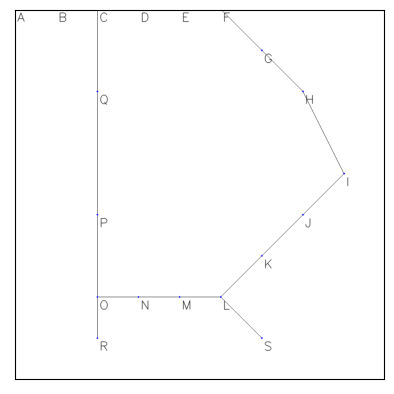

A, B, C, 
C, Q, P, O, 
O, R, 
O, N, M, L, 
L, S, 
L, K, J, I, H, G, F, E, D, C, 


In [4]:

graph = nx.Graph()
graph.add_edges_from([
    ((0, 0), (100, 0)),
    ((100, 0), (200, 0)),
    ((200, 0), (300, 0)),
    ((300, 0), (400, 0)),
    ((400, 0), (500, 0)),
    ((500, 0), (600, 100)),
    ((600, 100), (700, 200)),
    ((700, 200), (800, 400)),
    ((800, 400), (700, 500)),
    ((700, 500), (600, 600)),
    ((600, 600), (500, 700)),
    ((500, 700), (400, 700)),
    ((400, 700), (300, 700)),
    ((300, 700), (200, 700)),
    ((200, 700), (200, 500)),
    ((200, 500), (200, 200)),
    ((200, 200), (200, 0)),
    ((200, 700), (200, 800)),
    ((500, 700), (600, 800))
])

texts = {}
for index, node in enumerate(graph.nodes()):
    texts.update({node: chr(ord('A') + index)})


output = np.ones((900, 900, 3), np.uint8) * 255

# Draw edges
for u, v in graph.edges:
    x1, y1 = u
    x2, y2 = v
    cv2.line(output, (x1, y1), (x2, y2), (0, 0, 0), 1)
for x, y in graph.nodes:
    cv2.circle(output, (x, y,), 2, (0, 0, 255), -1)

for point, text in texts.items():
    cv2.putText(output, str(text), (point[0] + 5, point[1] + 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 1,
                cv2.LINE_AA)

plt.xticks([]), plt.yticks([])
plt.imshow(output)
plt.show()



paths = find_paths(graph)
for path in paths.values():
    for p in path:
        print(texts[p], end=", ")
    print()
